<h1>Lymphocyte Gating</h1>

Testing the performance of Immunova's automated gating algorithms at detecting lymphocyte populations gated using forward and sideward scatter. The accuracy, sensitivity, specificity and F1 score will be reported for each sample and then summarised as the average across all samples.

In [23]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
test_init()

In [2]:
def visualise_manual_ellipse(data, x, y, centroid, width, height, angle, xlim, ylim):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

<h2>Sep6</h2>

In [4]:
sep6 = Gating(exp, 'sep6')

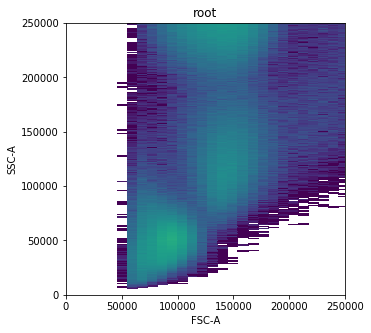

In [5]:
sep6.plotting.plot_population('root', 'FSC-A', 'SSC-A')

In [6]:
child_populations = ChildPopulationCollection('geom')

In [7]:
child_populations.add_population('lymphocytes', definition='+')
child_populations.add_population('not_lymphocytes', definition='-')

In [8]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(90000, 50000), width=100000, height=70000, angle=30)
sep6.create_gate(gate_name='manual_lymphocyte', parent='root', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

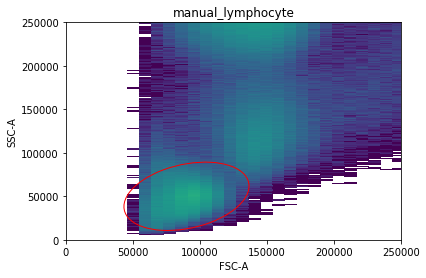

In [9]:
sep6.apply('manual_lymphocyte')

<h2>Mixture Model</h2>

In [10]:
child_populations = ChildPopulationCollection('geom')

In [11]:
child_populations.add_population('lymphocytes_mm', definition='+')
child_populations.add_population('not_lymphocytes_mm', definition='-')

In [12]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter)
sep6.create_gate(gate_name='gmm_lymphocyte', parent='root', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

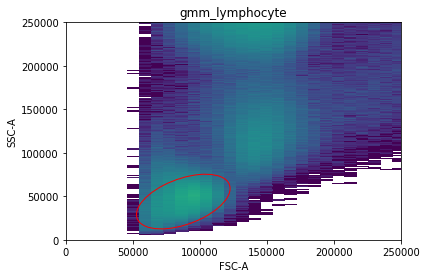

In [13]:
sep6.apply('gmm_lymphocyte')

In [21]:
sep6.populations['lymphocytes_mm'].index

array([      5,       9,      14, ..., 1004930, 1004933, 1004935])

In [26]:
def algo_performance(method_name, go, manual_pop, algo_pop):
    parent = go.populations[manual_pop].parent.name
    parent = go.get_population_df(parent).copy()
    manual_pop = go.populations[manual_pop].index
    algo_pop = go.populations[algo_pop].index
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(algo_pop), 1)
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    return pd.DataFrame({'method': [method_name], 'recall': [recall], 'precision': [precision],
                        'f1_score': [f1], 'accuracy': [accuracy]})

In [28]:
gmm_performance = algo_performance('Guassian Mixture Model', sep6, 'lymphocytes', 'lymphocytes_mm')
gmm_performance

,method,recall,precision,f1_score,accuracy
0,Guassian Mixture Model,0.88211,1.0,0.937363,0.977444


In [ ]:
visualise_manual_ellipse(sep6.get_population_df('root'), 'FSC-A', 'SSC-A', (90000, 50000), 100000, 70000, 30,
                        (0, 250000), (0,250000))